In [2]:
import os, time
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
device = "cuda"

In [29]:
trans = transforms.Compose([
        transforms.ColorJitter(0.2,0.2,0.2,0.5),
        transforms.RandomAffine(degrees=180,translate=(0.2,0.2),scale=[0.7,1.1],shear=15),
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1    
#         transforms.Normalize(mean=[0.08194405],std=[0.238141])  #comment this line when calculate ditribution
    ])

class KMnistDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None):
        self.is_validate = is_validate
        self.data = pd.read_csv("./dataset/train.csv")
        print("data shape:", np.shape(self.data))
        if data_len == None:
            data_len = len(self.data)
        
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
        idx += self.offset
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

In [15]:
vr = 0
train_dataset = KMnistDataset(data_len=None,is_validate=False, validate_rate=vr)
train_loader = DataLoader(train_dataset, batch_size=60000, shuffle=True, num_workers=0)

data shape: (60000, 785)


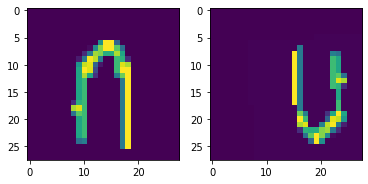

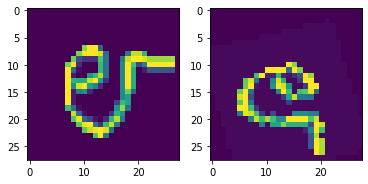

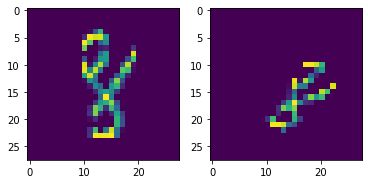

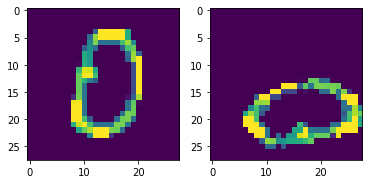

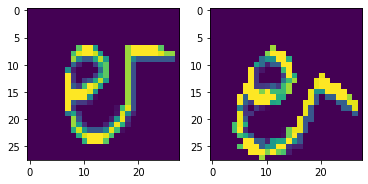

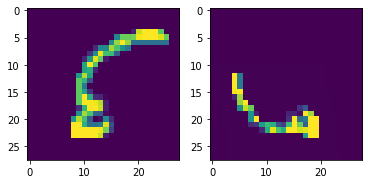

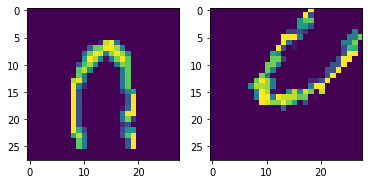

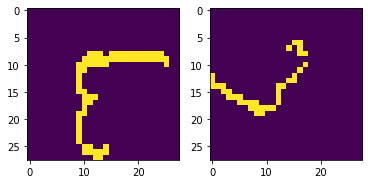

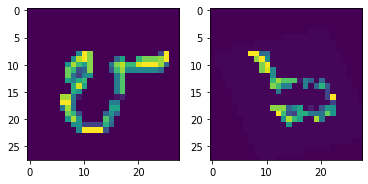

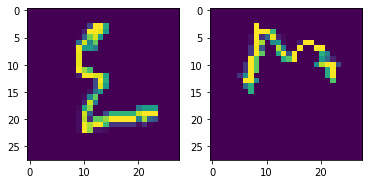

In [30]:
for i in range(10):
    idx = np.random.randint(0,60000)
    fig, axes = plt.subplots(1,2,figsize=(6,10))
    img = train_dataset.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))
    img = Image.fromarray(img)
    axes[0].imshow(img)
    img = trans(img)
    axes[1].imshow(img[0])
    plt.pause(.1)
    
    

Text(0, 0.5, 'frequency')

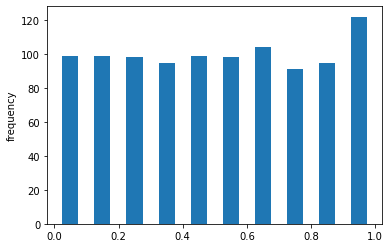

In [73]:
data = np.random.random([1000,])
plt.hist(data ,density=0,bins=10,label=True,rwidth=0.5)
# plt.hist(img[100].reshape(-1) ,density=1,bins=10,range=(0.2,1),label=True)
# print((label==5).sum().item())
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

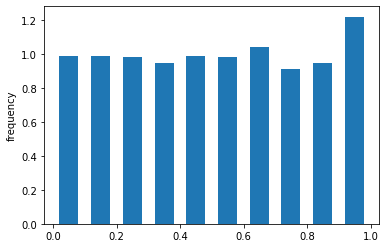

In [75]:
plt.hist(data ,density=1,bins=10,label=True,rwidth=0.6)
plt.ylabel('frequency')